## Fig S3: Definition of probability distributions in the calculation of mutual information.

Required packages:

In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt

fdir = '../data/'
out_fdir = '../plots/figS3/'

### 0. Loading input data

Same as in the notebook `fig3_architecture.ipynb`, we first load the required promoter sequence and energy matrices.

In [2]:
_genome = []
for record in SeqIO.parse(fdir + "mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv(fdir + 'ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

We manually specify the binding site sequences. Note that these sequences all need to be contained within the promoter sequence itself.

In [3]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = 'AATTGTGAGCGGATAACAATT'
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

We read in the known energy matrix for RNA polymerase. This energy matrix is experimentally determined and shown in Figure 2 of Brewster et al., 2012. (https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002). We use the function `fix_wt` from the `tregs` package to normalize the energy matrix such that the wild type base identities correspond to a binding energy of $0\ k_BT$.

In [4]:
rnap_emat_raw = np.loadtxt(fdir + 'energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

Similarly, we read in the experimentally determined energy matrix for the lacI repressor (Barnes et al., 2019) and normalize the energy matrix.

In [5]:
O1_1027_raw = np.load(fdir + 'energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### 1. Using ACGT instead of wild-type vs. mutant

There are two ways to define the probability distribution of mutations in the calculation of mutual information, one way is to only consider whether a base is wild-type or mutated, and one way is to consider the probability that a base is one of the four possible DNA bases. In order to choose a way to define this probability distribution, we produce information footprints from the same set of synthetic datasets with the simple repression architecture and compare the signal-to-noise ratio.

Firstly, we define the parameters needed to generate a synthetic dataset with the simple repression architecture.

In [6]:
n_NS = len(genome)
n_p = 5000
n_r = 10
ep_wt = -5
er_wt = -15

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]

In a for loop, we generate 20 synthetic datasets, calculate the information footprint for each dataset, and calculate the signal-to-noise ratio at all of the binding sites.

In [7]:
stn_ratio_cg = []
stn_ratio_wcg = []
for i in range(20):
    df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site],
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        num_mutants=5000)
    
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']
    nbins = 2
    upper_bound = np.mean(mu_data)
    n_seqs = len(mut_list)
    len_promoter = 160
    pseudocount = 10**(-6)

    footprint_cg = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))
    total_signal = 0
    for region in region_params:
        total_signal += np.sum(footprint_cg[(region[0]+115):(region[1]+116)])
    stn_ratio = total_signal / (np.sum(footprint_cg) - total_signal)
    stn_ratio_cg.append(stn_ratio)

    mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
    p_mu = tregs.footprint.get_p_mu(bin_cnt, n_seqs)

    letters = ['A', 'T', 'C', 'G']

    list_p_b = []
    for position in range(len_promoter):
        dict_cnt = {'A': 0, 'T': 0, 'C': 0, 'G': 0}
        for mut in mut_list:
            mut = mut.upper()
            letter = mut[position]
            dict_cnt[letter] += 1
        list_cnt = []
        for letter in letters:
            list_cnt.append(dict_cnt[letter])
        p_b = np.asarray(list_cnt) / n_seqs
        list_p_b.append(p_b)

    list_joint_p = []
    for position in range(len_promoter):
        joint_p = np.zeros((4, nbins)) + pseudocount
        # adding a pseudocount to prevent zero-division error
        for i, mut in enumerate(mut_list):
            mut = mut.upper()
            for j in range(nbins):
                for i_letter in range(4):
                    if (mut[position] == letters[i_letter]) & (mu_bins[i] == j):
                        joint_p[i_letter][j] += 1

        joint_p /= np.sum(joint_p)
        list_joint_p.append(joint_p)

    footprint_wcg = []
    for position in range(len_promoter):
        p_b = list_p_b[position]
        joint_p = list_joint_p[position]

        mi = 0
        for i in range(len(p_mu)):
            for i_letter in range(4):
                mi += joint_p[i_letter][i] * np.log2(joint_p[i_letter][i] / (p_b[i_letter] * p_mu[i]))
        footprint_wcg.append(mi)

    total_signal = 0
    for region in region_params:
        total_signal += np.sum(footprint_wcg[(region[0]+115):(region[1]+116)])
    stn_ratio = total_signal / (np.sum(footprint_wcg) - total_signal)
    stn_ratio_wcg.append(stn_ratio)

We plot the mean and standard deviation of the signal-to-noise ratio from footprints calculated using each of the two definitions.

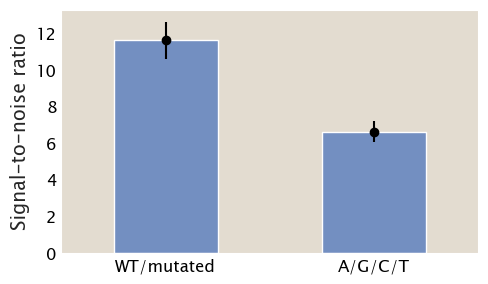

In [8]:
fig, ax = plt.subplots(figsize=(5.2,3))

x = ['WT/mutated', 'A/G/C/T']
y = [np.mean(stn_ratio_cg), np.mean(stn_ratio_wcg)]

ax.bar(x, y, width=0.5, color='#738FC1', edgecolor=None, align='center')
ax.errorbar(x, y, yerr=[np.std(stn_ratio_cg), np.std(stn_ratio_wcg)], fmt="o", color='black')
#ax.set_xticks(x, label=x_ticks)
ax.set_ylabel('Signal-to-noise ratio', fontsize=14)
ax.set_xlim(-0.5, 1.5)
 
plt.tight_layout()
plt.savefig(out_fdir + 'stn_atcg.pdf', dpi=300)
plt.show()

### 2. Varying bin sizes

When we are calculating mutual information, we also need to define the probability distribution of expression levels. We do this by grouping sequences into expression bins and calculating the probability that the expression level of each promoter variant falls into each bin. As a result, we need to choose an appropriate number of bins to define this probability distribution.

For convenience, we define the function below `get_signal` where we calculate the average mutual information at a binding site given the footprint and the left and right indices of the binding site.

In [6]:
def get_signal(footprint, region_param):
    """
    Calculate the total mutual information within a binding site and the length of the binding site.

    Parameters:
    ----------
    footprint : array
        Array containing mutual information of a promoter.
    region_param : tuple of int
        Tuple specifying the start and end indices (inclusive) of the binding site.

    Returns:
    -------
    signal : float
        The sum of the mutual information within the binding site.
    length : int
        The length of the binding site.
    """
    signal = np.sum(footprint[(region_param[0]+115):(region_param[1]+116)])
    length = region_param[1] - region_param[0] + 1
    return signal, length

To save computational time, we also generate 20 mutant libraries beforehand using the function `mutations_rand` and we produce the synthetic datasets beforehand.

In [7]:
n_NS = len(genome)
n_p = 5000
n_r = 10
ep_wt = -5
er_wt = -15

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]

datasets = []
for i in range(20):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    
    df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site],
                                *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                preset_mutants=mutants,
                                num_mutants=5000)
    
    datasets.append(df)

For each of the 20 synthetic datasets, we calculate the information footprint and keep track of the signal-to-noise ratio at each of the RNAP and repressor binding sites.

In [8]:
l_nbins = np.arange(2, 11, 1)

l_stn_ratio_rnap10 = []
l_stn_ratio_rnap35 = []
l_stn_ratio_lacI = []
for i in range(len(l_nbins)):
    rnap10 = []
    rnap35 = []
    lacI = []
    for j in range(len(datasets)):
        nbins = l_nbins[i]

        df = datasets[j]
        
        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.quantile(mu_data, 1 - 1 / nbins)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=10**(-6))
        
        region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
        rnap35_signal, rnap35_length = get_signal(footprint, region_params[0])
        rnap10_signal, rnap10_length = get_signal(footprint, region_params[1])
        lacI_signal, lacI_length = get_signal(footprint, region_params[2])

        total_signal = rnap35_signal + rnap10_signal + lacI_signal
        total_noise = np.sum(footprint) - total_signal
        mean_noise = total_noise / (160 - (rnap35_length + rnap10_length + lacI_length))
        
        rnap10.append(rnap10_signal / rnap10_length / mean_noise)
        rnap35.append(rnap35_signal / rnap35_length / mean_noise)
        lacI.append(lacI_signal / lacI_length / mean_noise)
    l_stn_ratio_rnap10.append(np.mean(rnap10))
    l_stn_ratio_rnap35.append(np.mean(rnap35))
    l_stn_ratio_lacI.append(np.mean(lacI))

We plot signal-to-noise ratio at the -10 and -35 RNAP binding sites and the lacI binding site against the number of bins.

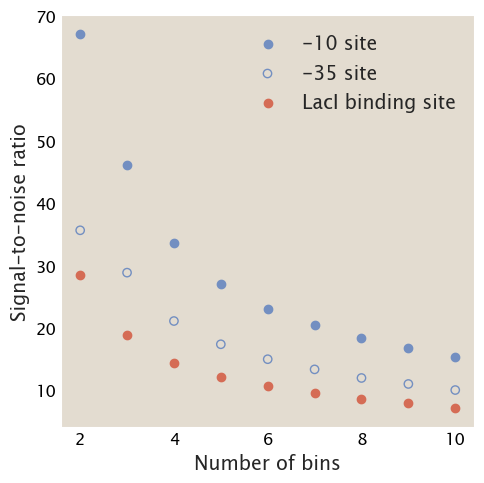

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(l_nbins, l_stn_ratio_rnap10, label='-10 site', color='#738FC1')
ax.scatter(l_nbins, l_stn_ratio_rnap35, label='-35 site', facecolors='none', edgecolors='#738FC1', )
ax.scatter(l_nbins, l_stn_ratio_lacI, label='LacI binding site',
           color='#D56C55')
ax.set_xlabel('Number of bins', fontsize=14)
ax.set_ylabel('Signal-to-noise ratio',fontsize=14)
ax.legend(loc='upper right', frameon=False, fontsize=14)

plt.tight_layout()
plt.savefig(out_fdir + 'bin-size.pdf')

### 3. Example footprints with different definition of probability distributions

We plot a few example information footprints calculated using different number of bins and different ways to account for the probability of base identities. First, we generate another synthetic dataset with the simple repression regulatory architecture.

In [10]:
n_NS = len(genome)
n_p = 5000
n_r = 10
ep_wt = -5
er_wt = -15

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site],
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        preset_mutants=mutants,
                        num_mutants=5000)

We first calculate an information footprint with coarse-grained definition of base identity and 2 bins

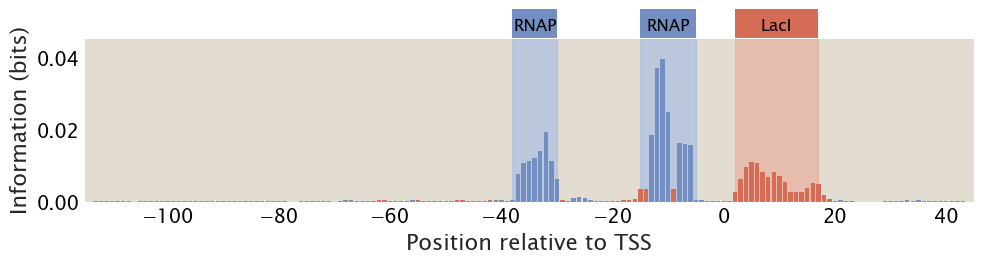

In [12]:
tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=2,
                               outfile=out_fdir + 'footprint-cg-2bins.pdf')

Next, we calculate an information footprint with 2 bins but accounts for all four possible base identities at each site.

In [13]:
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = np.mean(mu_data)
n_seqs = len(mut_list)
len_promoter = 160
pseudocount = 10**(-6)

mu_bins, bin_cnt = tregs.footprint.bin_expression_levels(mu_data, nbins, upper_bound)
p_mu = tregs.footprint.get_p_mu(bin_cnt, n_seqs)

letters = ['A', 'T', 'C', 'G']

list_p_b = []
for position in range(len_promoter):
    dict_cnt = {'A': 0, 'T': 0, 'C': 0, 'G': 0}
    for mut in mut_list:
        mut = mut.upper()
        letter = mut[position]
        dict_cnt[letter] += 1
    list_cnt = []
    for letter in letters:
        list_cnt.append(dict_cnt[letter])
    p_b = np.asarray(list_cnt) / n_seqs
    list_p_b.append(p_b)

list_joint_p = []
for position in range(len_promoter):
    joint_p = np.zeros((4, nbins)) + pseudocount
    # adding a pseudocount to prevent zero-division error
    for i, mut in enumerate(mut_list):
        mut = mut.upper()
        for j in range(nbins):
            for i_letter in range(4):
                if (mut[position] == letters[i_letter]) & (mu_bins[i] == j):
                    joint_p[i_letter][j] += 1

    joint_p /= np.sum(joint_p)
    list_joint_p.append(joint_p)

footprint_wcg = []
for position in range(len_promoter):
    p_b = list_p_b[position]
    joint_p = list_joint_p[position]

    mi = 0
    for i in range(len(p_mu)):
        for i_letter in range(4):
            mi += joint_p[i_letter][i] * np.log2(joint_p[i_letter][i] / (p_b[i_letter] * p_mu[i]))
    footprint_wcg.append(mi)

The information footprint is plotted below.

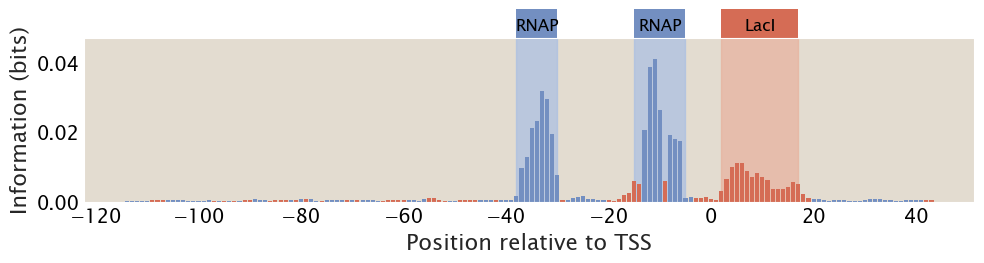

In [16]:
region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]

fig, ax = plt.subplots(figsize=(10,2.9))
ax.set_ylabel('Information (bits)', fontsize=16)
ax.set_xlabel('Position relative to TSS', fontsize=16)

footprint = footprint_wcg

windowsize = 3
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter)
shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]

cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
footprint_smoothed = tregs.utils.smoothing(footprint, windowsize=windowsize)

ax.set_ylim(top=max(footprint_smoothed)*1.15)
max_signal = max(footprint_smoothed)
total_signal = 0
for region in region_params:
    tregs.footprint.label_binding_site(ax, region[0], region[1], max_signal, region[2], region[3])
    total_signal += np.sum(footprint[(region[0]+115):(region[1]+116)])
stn_ratio = total_signal / (np.sum(footprint) - total_signal)

ax.bar(x, footprint_smoothed, edgecolor=None, color=shiftcolors, linewidth=0)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.savefig(out_fdir + 'footprint-wcg.pdf')
plt.show()

Finally, we plot an information footprint that calculates the probability distribution of expression levels using 10 bins.

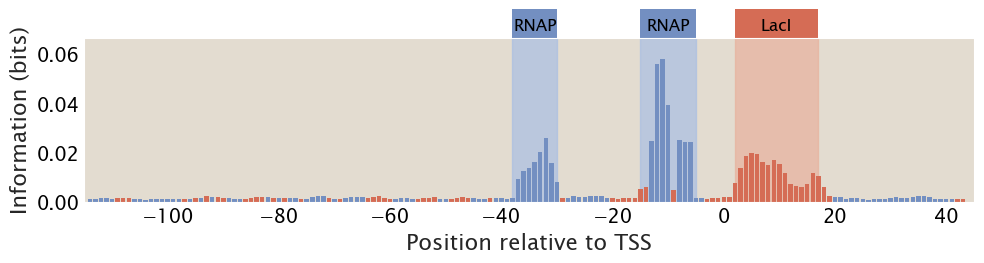

In [17]:
tregs.footprint.plot_footprint(promoter, df, region_params,
                               nbins=10,
                               outfile=out_fdir + 'footprint-cg-10bins.pdf')